In [1]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path

%matplotlib inline

In [2]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values

In [3]:
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


In [4]:
idxes = list(range(len(series)))

In [5]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8

In [6]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [23]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

In [24]:
model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(50, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 1 / 17, loss 0.887:   6%|▌         | 1/17 [00:00<00:01,  9.05it/s]

epoch 1 / 50: train loss 1.065 val loss 1.153 RMSE 178.948


batch 1 / 17, loss 0.758:   6%|▌         | 1/17 [00:00<00:02,  7.87it/s]

epoch 2 / 50: train loss 0.896 val loss 1.017 RMSE 169.886


batch 1 / 17, loss 0.849:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 3 / 50: train loss 0.822 val loss 0.946 RMSE 165.823


batch 2 / 17, loss 0.728:  12%|█▏        | 2/17 [00:00<00:01, 14.34it/s]

epoch 4 / 50: train loss 0.785 val loss 0.930 RMSE 164.611


batch 2 / 17, loss 0.781:  12%|█▏        | 2/17 [00:00<00:01, 11.41it/s]

epoch 5 / 50: train loss 0.772 val loss 0.927 RMSE 164.244


batch 2 / 17, loss 0.708:  12%|█▏        | 2/17 [00:00<00:01, 10.29it/s]

epoch 6 / 50: train loss 0.755 val loss 0.874 RMSE 158.372


batch 2 / 17, loss 0.539:   6%|▌         | 1/17 [00:00<00:01,  9.22it/s]

epoch 7 / 50: train loss 0.696 val loss 0.834 RMSE 153.884


batch 2 / 17, loss 0.856:  12%|█▏        | 2/17 [00:00<00:01, 10.31it/s]

epoch 8 / 50: train loss 0.657 val loss 0.883 RMSE 158.863


batch 2 / 17, loss 0.545:  12%|█▏        | 2/17 [00:00<00:01, 12.24it/s]

epoch 9 / 50: train loss 0.652 val loss 0.782 RMSE 149.488


batch 2 / 17, loss 0.775:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 10 / 50: train loss 0.572 val loss 0.765 RMSE 147.581


batch 1 / 17, loss 0.640:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 11 / 50: train loss 0.569 val loss 0.743 RMSE 145.057


batch 1 / 17, loss 0.438:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 12 / 50: train loss 0.580 val loss 0.753 RMSE 145.836


batch 1 / 17, loss 0.428:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 13 / 50: train loss 0.552 val loss 0.718 RMSE 141.909


batch 2 / 17, loss 0.482:  12%|█▏        | 2/17 [00:00<00:00, 15.47it/s]

epoch 14 / 50: train loss 0.505 val loss 0.714 RMSE 142.374


batch 1 / 17, loss 0.521:   6%|▌         | 1/17 [00:00<00:02,  6.33it/s]

epoch 15 / 50: train loss 0.505 val loss 0.698 RMSE 139.455


batch 2 / 17, loss 0.615:  12%|█▏        | 2/17 [00:00<00:01, 13.21it/s]

epoch 16 / 50: train loss 0.497 val loss 0.672 RMSE 138.534


batch 2 / 17, loss 0.440:  12%|█▏        | 2/17 [00:00<00:01, 13.86it/s]

epoch 17 / 50: train loss 0.470 val loss 0.652 RMSE 135.377


batch 1 / 17, loss 0.439:   6%|▌         | 1/17 [00:00<00:02,  7.62it/s]

epoch 18 / 50: train loss 0.442 val loss 0.638 RMSE 133.528


batch 3 / 17, loss 0.381:  12%|█▏        | 2/17 [00:00<00:00, 15.69it/s]

epoch 19 / 50: train loss 0.442 val loss 0.852 RMSE 159.669


batch 3 / 17, loss 0.376:  12%|█▏        | 2/17 [00:00<00:00, 15.37it/s]

epoch 20 / 50: train loss 0.478 val loss 0.835 RMSE 155.081


batch 2 / 17, loss 0.442:  12%|█▏        | 2/17 [00:00<00:01, 13.51it/s]

epoch 21 / 50: train loss 0.451 val loss 0.645 RMSE 134.999


batch 2 / 17, loss 0.330:  12%|█▏        | 2/17 [00:00<00:01, 13.01it/s]

epoch 22 / 50: train loss 0.412 val loss 0.606 RMSE 129.742


batch 3 / 17, loss 0.280:  12%|█▏        | 2/17 [00:00<00:00, 17.81it/s]

epoch 23 / 50: train loss 0.368 val loss 0.609 RMSE 129.081


batch 1 / 17, loss 0.408:   6%|▌         | 1/17 [00:00<00:01,  8.85it/s]

epoch 24 / 50: train loss 0.356 val loss 0.592 RMSE 128.137


batch 2 / 17, loss 0.290:  12%|█▏        | 2/17 [00:00<00:01, 10.58it/s]

epoch 25 / 50: train loss 0.343 val loss 0.592 RMSE 126.834


batch 3 / 17, loss 0.269:  12%|█▏        | 2/17 [00:00<00:00, 15.82it/s]

epoch 26 / 50: train loss 0.329 val loss 0.557 RMSE 121.359


batch 2 / 17, loss 0.398:  12%|█▏        | 2/17 [00:00<00:01, 12.64it/s]

epoch 27 / 50: train loss 0.335 val loss 0.539 RMSE 119.793


batch 2 / 17, loss 0.333:  12%|█▏        | 2/17 [00:00<00:01, 11.76it/s]

epoch 28 / 50: train loss 0.304 val loss 0.532 RMSE 117.052


batch 2 / 17, loss 0.238:  12%|█▏        | 2/17 [00:00<00:01, 13.89it/s]

epoch 29 / 50: train loss 0.295 val loss 0.522 RMSE 116.525


batch 2 / 17, loss 0.267:  12%|█▏        | 2/17 [00:00<00:01, 10.32it/s]

epoch 30 / 50: train loss 0.276 val loss 0.508 RMSE 115.050


batch 2 / 17, loss 0.391:  12%|█▏        | 2/17 [00:00<00:01, 11.89it/s]

epoch 31 / 50: train loss 0.285 val loss 0.513 RMSE 114.558


batch 1 / 17, loss 0.337:   6%|▌         | 1/17 [00:00<00:02,  7.67it/s]

epoch 32 / 50: train loss 0.273 val loss 0.487 RMSE 110.741


batch 1 / 17, loss 0.336:   6%|▌         | 1/17 [00:00<00:02,  7.80it/s]

epoch 33 / 50: train loss 0.260 val loss 0.477 RMSE 109.078


batch 1 / 17, loss 0.219:   6%|▌         | 1/17 [00:00<00:02,  7.25it/s]

epoch 34 / 50: train loss 0.244 val loss 0.473 RMSE 108.109


batch 1 / 17, loss 0.227:   6%|▌         | 1/17 [00:00<00:02,  7.39it/s]

epoch 35 / 50: train loss 0.246 val loss 0.462 RMSE 106.471


batch 2 / 17, loss 0.217:  12%|█▏        | 2/17 [00:00<00:01, 11.13it/s]

epoch 36 / 50: train loss 0.238 val loss 0.445 RMSE 104.493


batch 1 / 17, loss 0.226:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 37 / 50: train loss 0.221 val loss 0.442 RMSE 103.767


batch 2 / 17, loss 0.278:   6%|▌         | 1/17 [00:00<00:01,  8.41it/s]

epoch 38 / 50: train loss 0.221 val loss 0.432 RMSE 102.270


batch 1 / 17, loss 0.198:   6%|▌         | 1/17 [00:00<00:01,  9.95it/s]

epoch 39 / 50: train loss 0.213 val loss 0.434 RMSE 101.710


batch 1 / 17, loss 0.345:   6%|▌         | 1/17 [00:00<00:01,  9.28it/s]

epoch 40 / 50: train loss 0.210 val loss 0.427 RMSE 100.830


batch 2 / 17, loss 0.174:  12%|█▏        | 2/17 [00:00<00:01, 13.55it/s]

epoch 41 / 50: train loss 0.214 val loss 0.421 RMSE 100.223


batch 2 / 17, loss 0.248:   6%|▌         | 1/17 [00:00<00:01,  9.84it/s]

epoch 42 / 50: train loss 0.200 val loss 0.419 RMSE 100.295


batch 1 / 17, loss 0.335:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 43 / 50: train loss 0.198 val loss 0.427 RMSE 101.361


batch 2 / 17, loss 0.162:  12%|█▏        | 2/17 [00:00<00:01, 12.32it/s]

epoch 44 / 50: train loss 0.208 val loss 0.405 RMSE 97.877


batch 3 / 17, loss 0.159:  12%|█▏        | 2/17 [00:00<00:01, 14.89it/s]

epoch 45 / 50: train loss 0.192 val loss 0.409 RMSE 98.040


batch 2 / 17, loss 0.206:  12%|█▏        | 2/17 [00:00<00:01, 13.95it/s]

epoch 46 / 50: train loss 0.194 val loss 0.400 RMSE 96.719


batch 2 / 17, loss 0.183:  12%|█▏        | 2/17 [00:00<00:01, 14.53it/s]

epoch 47 / 50: train loss 0.197 val loss 0.399 RMSE 96.404


batch 2 / 17, loss 0.230:  12%|█▏        | 2/17 [00:00<00:01, 10.48it/s]

epoch 48 / 50: train loss 0.195 val loss 0.396 RMSE 96.246


batch 2 / 17, loss 0.153:  12%|█▏        | 2/17 [00:00<00:01, 14.25it/s]

epoch 49 / 50: train loss 0.193 val loss 0.396 RMSE 95.851


batch 17 / 17, loss 0.151: 100%|██████████| 17/17 [00:01<00:00, 10.65it/s]


epoch 50 / 50: train loss 0.189 val loss 0.394 RMSE 95.583
best model save in /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs/Seq2Seq_epoch_50_0.394.pkl


In [25]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.189, valid loss: 0.394, test loss :0.519, test RMSE :111.039, 


In [26]:
len(series)

239

In [27]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)

In [28]:
import seaborn as sns

In [29]:
def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')

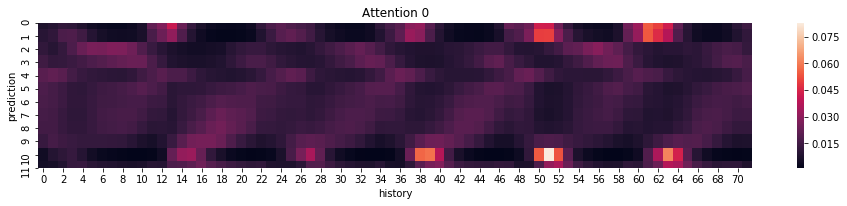

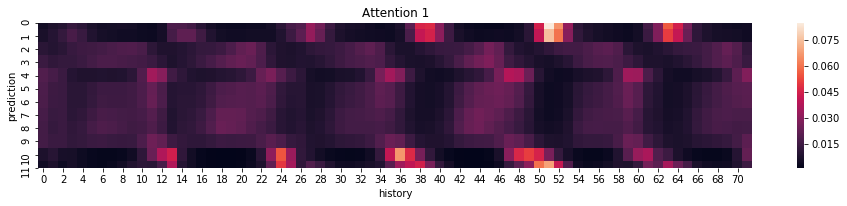

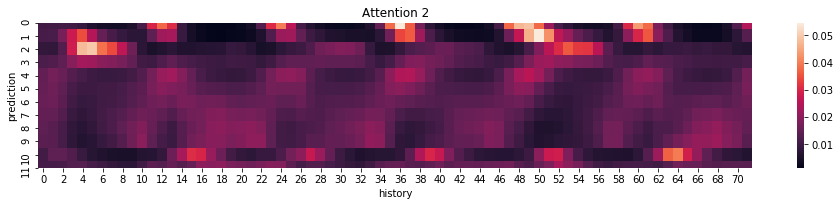

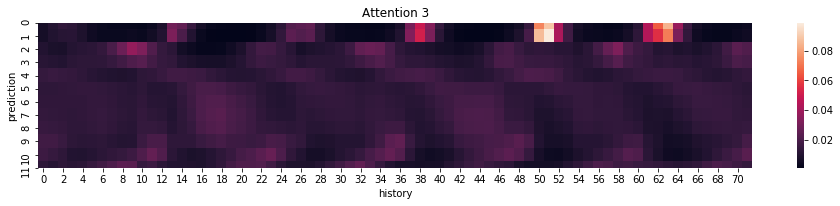

In [30]:
plot_attentions(attns)

In [57]:
attn.shape

(1, 12, 2, 128)